# Multi-armed Bandit Problem

In [263]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [264]:
class MultiArmedBandit:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.normal(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]

    def play(self, arm: int) -> float:
        mean = self.means[arm]
        return np.random.normal(mean, 1)
    


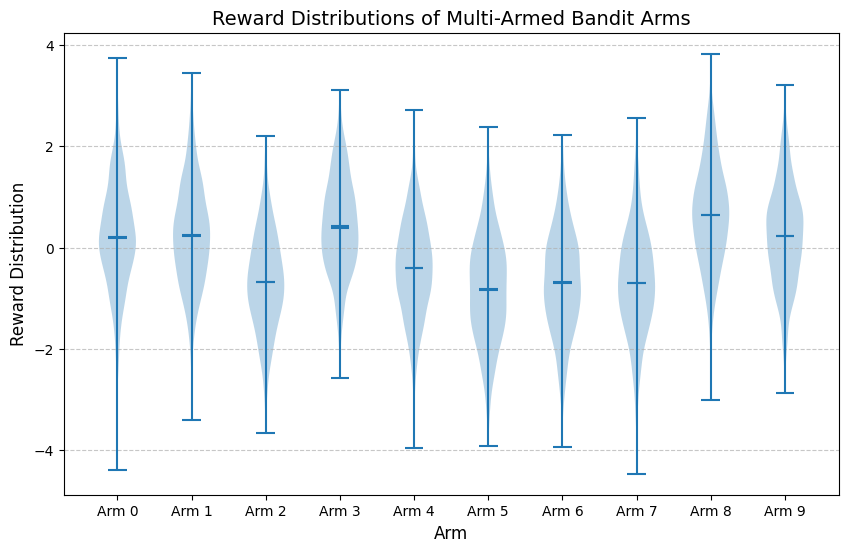

In [265]:
def plot_bandit(bandit: MultiArmedBandit):
    # Simulate rewards for each arm to create a distribution
    rewards = []
    for arm in range(bandit.number_of_arms):
        simulated_rewards = [bandit.play(arm) for _ in range(1000)]  # Simulate 1000 plays per arm
        rewards.append(simulated_rewards)
    
    plt.figure(figsize=(10, 6))
    plt.violinplot(rewards, showmeans=True, showmedians=True)
    plt.xlabel("Arm", fontsize=12)
    plt.ylabel("Reward Distribution", fontsize=12)
    plt.title("Reward Distributions of Multi-Armed Bandit Arms", fontsize=14)
    plt.xticks(range(1, bandit.number_of_arms + 1), [f'Arm {i}' for i in range(bandit.number_of_arms)], fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a MultiArmedBandit instance and plot using a violin plot
bandit = MultiArmedBandit(10)
plot_bandit(bandit)

In [266]:
# random agent for a baseline
class RandomAgent:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms

    def choose_action(self) -> int:
        return random.randint(0, self.number_of_arms - 1)
    
    def update(self, arm: int, reward: float) -> None:
        pass
    

In [267]:
def run_and_collect_data(agent, bandit, num_steps):
    rewards = []
    best_action_counts = []
    regrets = []
    for _ in range(num_steps):
        action = agent.choose_action()
        reward = bandit.play(action)
        rewards.append(reward)
        best_action_counts.append(action == bandit.optimal_arm)
        regrets.append(bandit.optimal_mean - bandit.means[action])
        agent.update(action, reward)
    return rewards, best_action_counts, regrets


In [268]:
# Function to run the bandit problem for multiple agents and plot the results
def run_and_plot_for_agents(agents, agent_names, bandit, num_steps):
    # Initialize storage for results
    all_rewards = []
    all_best_action_counts = []
    all_regrets = []

    # Run the simulation for each agent
    for agent in agents:
        rewards, best_action_counts, regrets = run_and_collect_data(agent, bandit, num_steps)
        all_rewards.append(rewards)
        all_best_action_counts.append(best_action_counts)
        all_regrets.append(regrets)
    
    # Calculate average results across all agents
    average_rewards = [np.cumsum(rewards) / (np.arange(len(rewards)) + 1) for rewards in all_rewards]
    average_best_action_counts = [np.cumsum(best_action_counts) / (np.arange(len(best_action_counts)) + 1) for best_action_counts in all_best_action_counts]
    cumulative_regrets = [np.cumsum(regrets) for regrets in all_regrets]
    
    # Plot the results
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    
    for i, (agent, name) in enumerate(zip(agents, agent_names)):
        ax[0].plot(average_rewards[i], label=f'{name}')
        ax[1].plot(average_best_action_counts[i], label=f'{name}')
        ax[2].plot(cumulative_regrets[i], label=f'{name}')
    
    # Customize plots
    ax[0].set_xlabel('Steps', fontsize=12)
    ax[0].set_ylabel('Average Reward', fontsize=12)
    ax[0].set_title('Average Reward vs Steps', fontsize=14)
    ax[0].grid(linestyle='--', alpha=0.7)
    ax[0].legend()

    ax[1].set_xlabel('Steps', fontsize=12)
    ax[1].set_ylabel('Best Action Count', fontsize=12)
    ax[1].set_title('Best Action Count vs Steps', fontsize=14)
    ax[1].grid(linestyle='--', alpha=0.7)
    ax[1].legend()

    ax[2].set_xlabel('Steps', fontsize=12)
    ax[2].set_ylabel('Regret', fontsize=12)
    ax[2].set_title('Regret vs Steps', fontsize=14)
    ax[2].grid(linestyle='--', alpha=0.7)
    ax[2].legend()

    plt.tight_layout()
    plt.show()


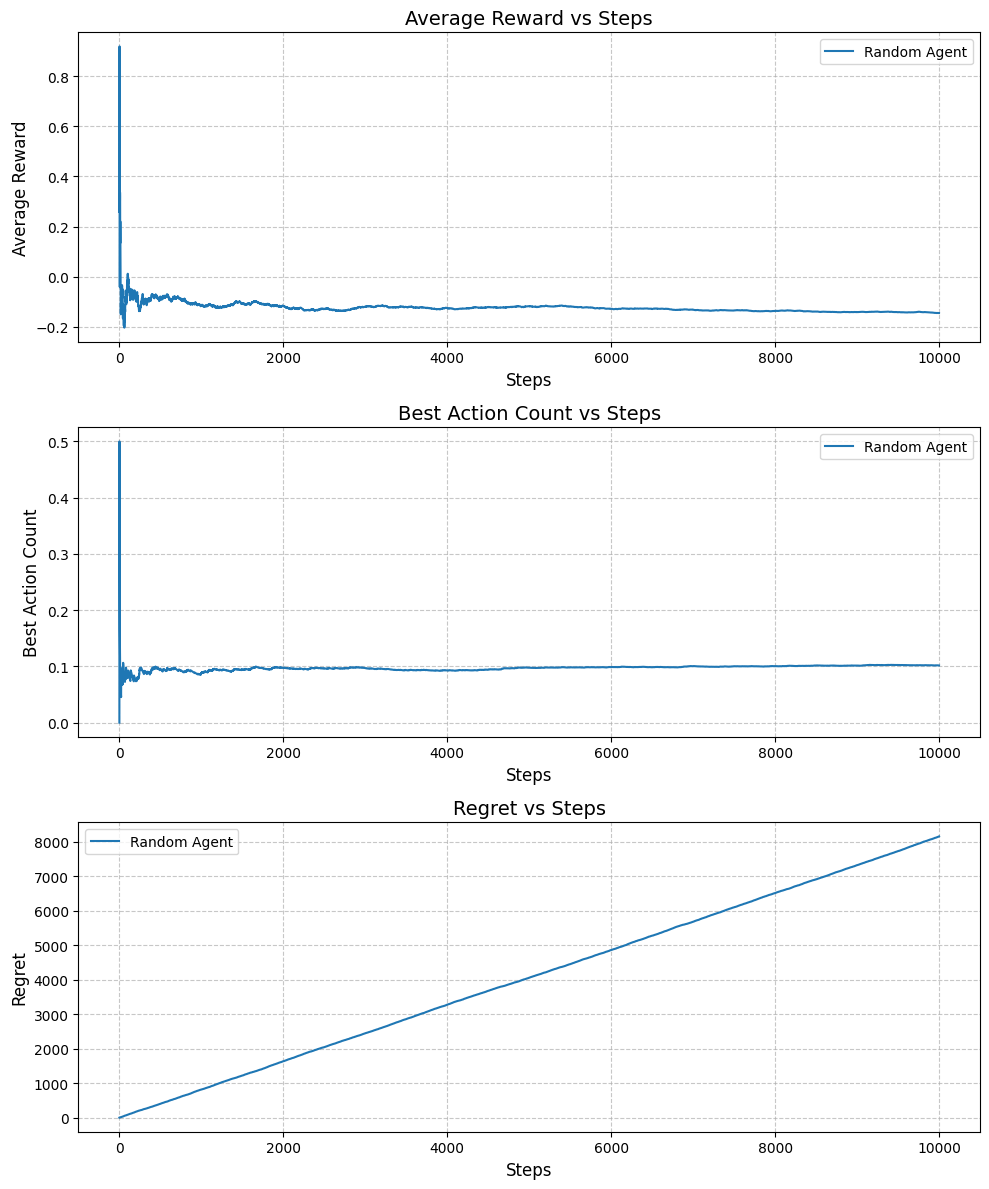

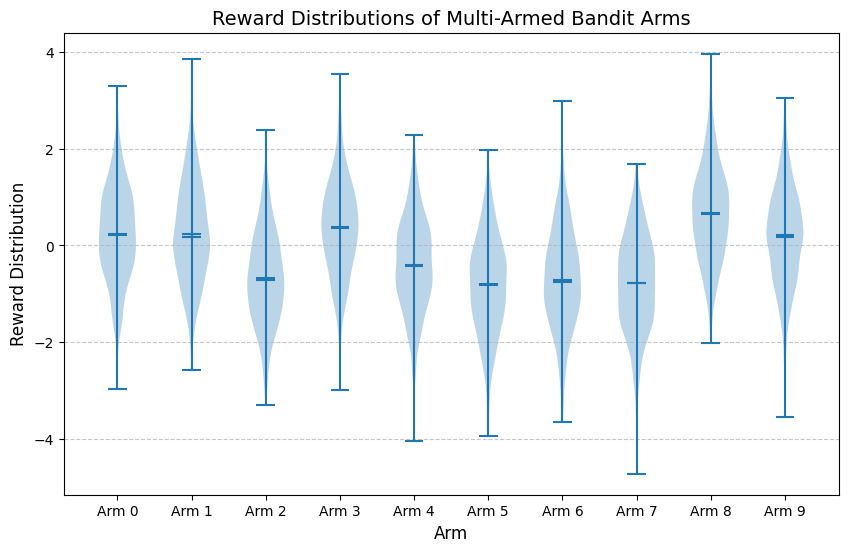

In [269]:
random_agent = RandomAgent(bandit)
agents = [random_agent]
agent_names = ['Random Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)
plot_bandit(random_agent.bandit)

# Explore-Then-Exploit

In [270]:
# a agent that explore every arm N times and then exploit the best arm
class ExploreThenExploit:
    def __init__(self, bandit: MultiArmedBandit, N: int) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms
        self.N = N
        self.action_count = np.zeros(self.number_of_arms)
        self.estimated_means = np.zeros(self.number_of_arms)
        self.stop_exploring = False
        
        self._iter = []


    def choose_action(self) -> int:
        if np.any(self.action_count < self.N):
            return np.argmin(self.action_count)
        
        self.stop_exploring = True
        return np.argmax(self.estimated_means)


    def update(self, arm: int, reward: float) -> None:
        self.estimated_means[arm] += reward / self.N
        return 0


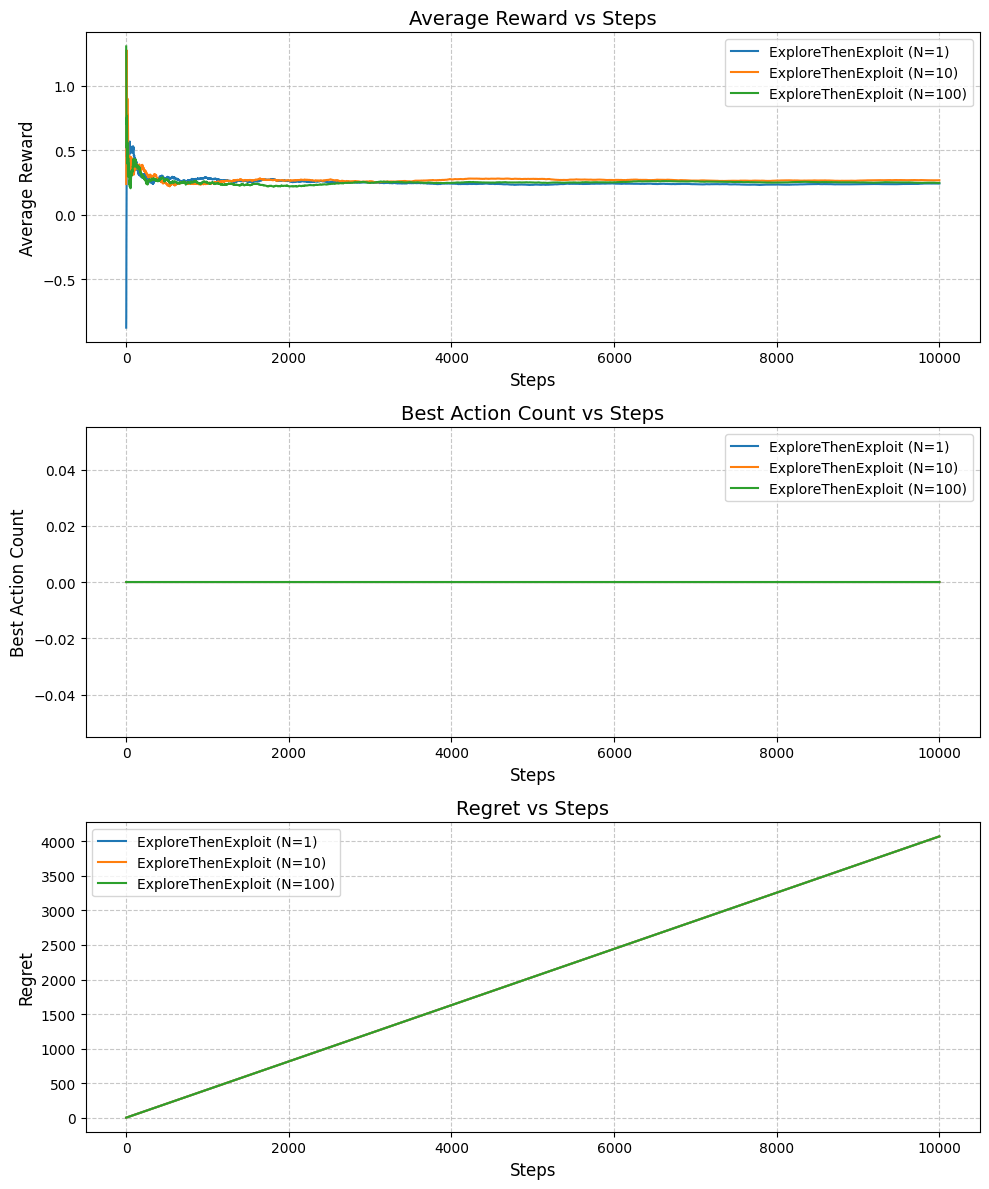

In [271]:
# run ExploreThenExploit agent for different values of N
agents = [ExploreThenExploit(bandit, N) for N in [1, 10, 100]]
agent_names = ['ExploreThenExploit (N=1)', 'ExploreThenExploit (N=10)', 'ExploreThenExploit (N=100)']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Epsilon-Greedy

In [272]:
class EpsilonGreedy:
    def __init__(self, bandit: MultiArmedBandit, epsilon: float=0.1) -> None:
        self.bandit = bandit
        self.epsilon = epsilon
        self.number_of_arms = bandit.number_of_arms
        self.estimated_means = np.zeros(self.number_of_arms)
        self.action_counts = np.zeros(self.number_of_arms)

    def choose_action(self) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.number_of_arms-1)
        else:
            return np.argmax(self.estimated_means)
        
    def update(self, arm: int, reward: float) -> None:
        self.action_counts[arm] += 1
        self.estimated_means[arm] += (reward - self.estimated_means[arm]) / self.action_counts[arm]
        return 0

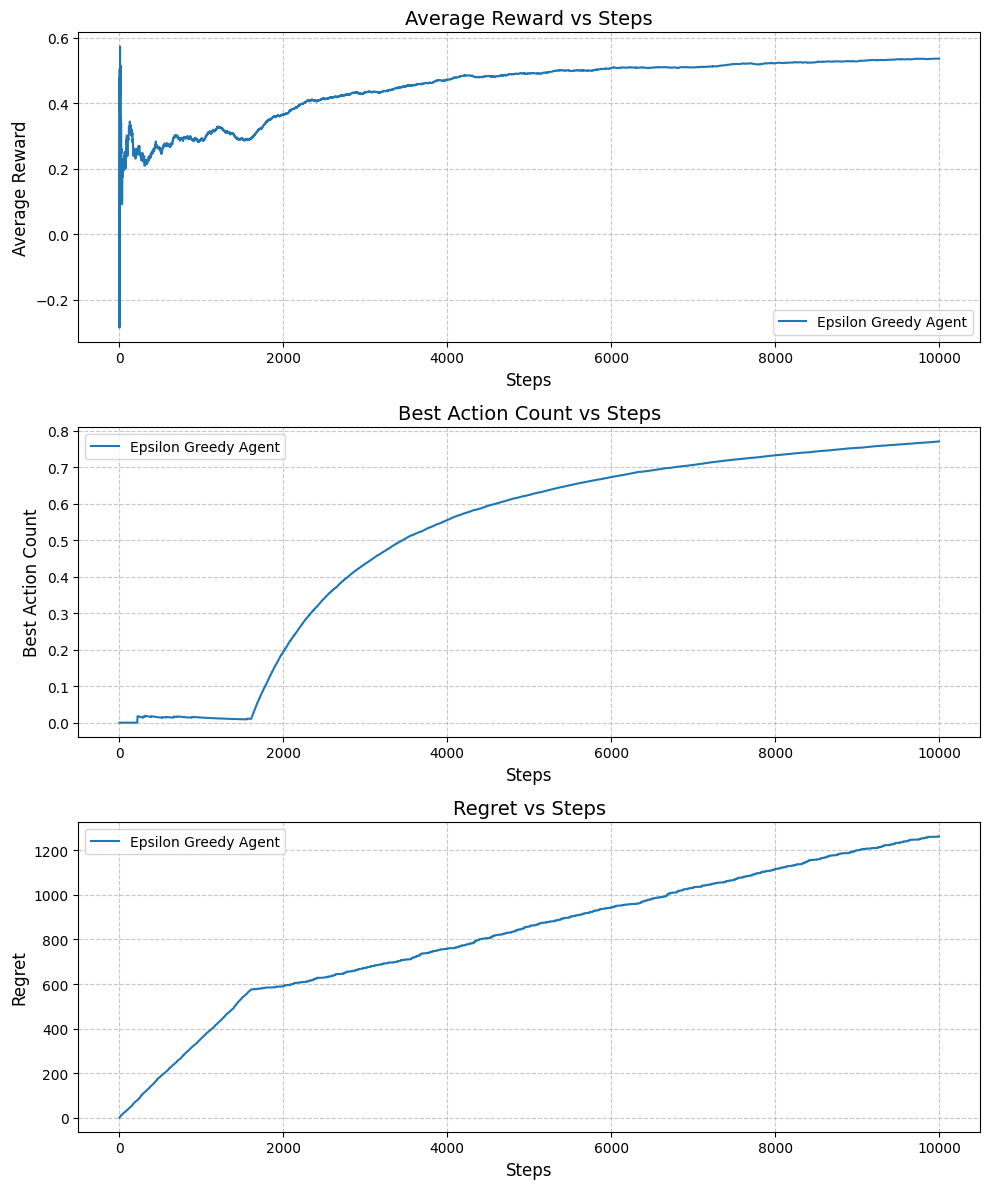

In [273]:
# Run the epsilon-greedy agent and plot the results
epsilon_greedy_agent = EpsilonGreedy(bandit, epsilon=0.1)
agents = [epsilon_greedy_agent]
agent_names = ['Epsilon Greedy Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Upper Confidence Bounds (UCB algorithm)

In [274]:
class UCB:
    def __init__(self, bandit: MultiArmedBandit, c: float=2) -> None:
        self.bandit = bandit
        
        self.c = c
        self.number_of_arms = bandit.number_of_arms
        self.estimated_means = np.zeros(self.number_of_arms)
        self.action_counts = np.zeros(self.number_of_arms)
        
        self._T = 0

    def choose_action(self) -> int:
        arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / (self.action_counts + 1e-7)))
        self._T += 1
        return arm
        
    def update(self, arm: int, reward: float) -> None:
        self.action_counts[arm] += 1
        self.estimated_means[arm] += (reward - self.estimated_means[arm]) / self.action_counts[arm]
        return 0

/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: divide by zero encountered in log
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: invalid value encountered in sqrt
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: invalid value encountered in divide
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: divide by zero encountered in divide
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))


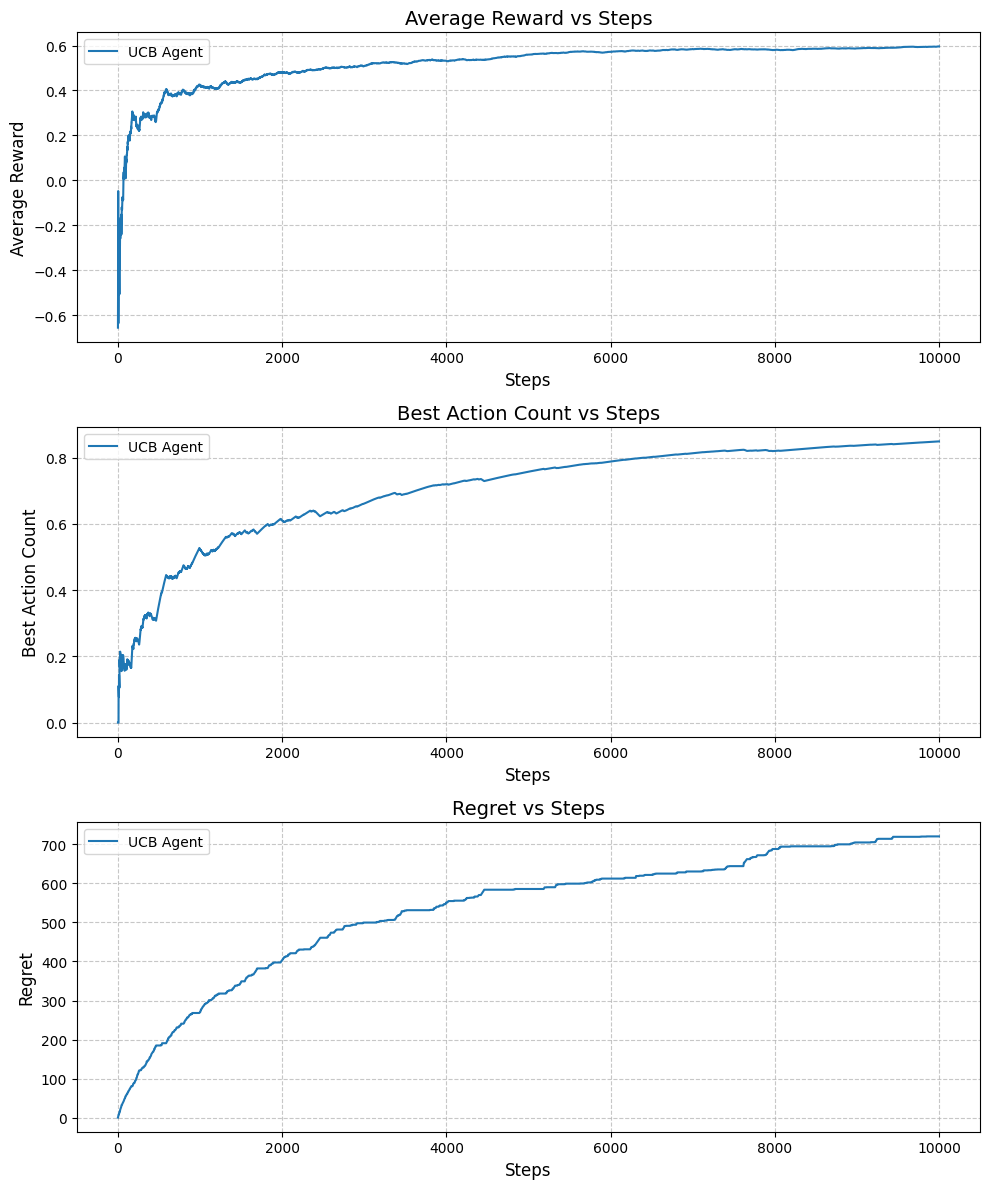

In [275]:
ucb_agent = UCB(bandit, c=2)
agents = [ucb_agent]
agent_names = ['UCB Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)


# Epsilon-greedy versus UCB

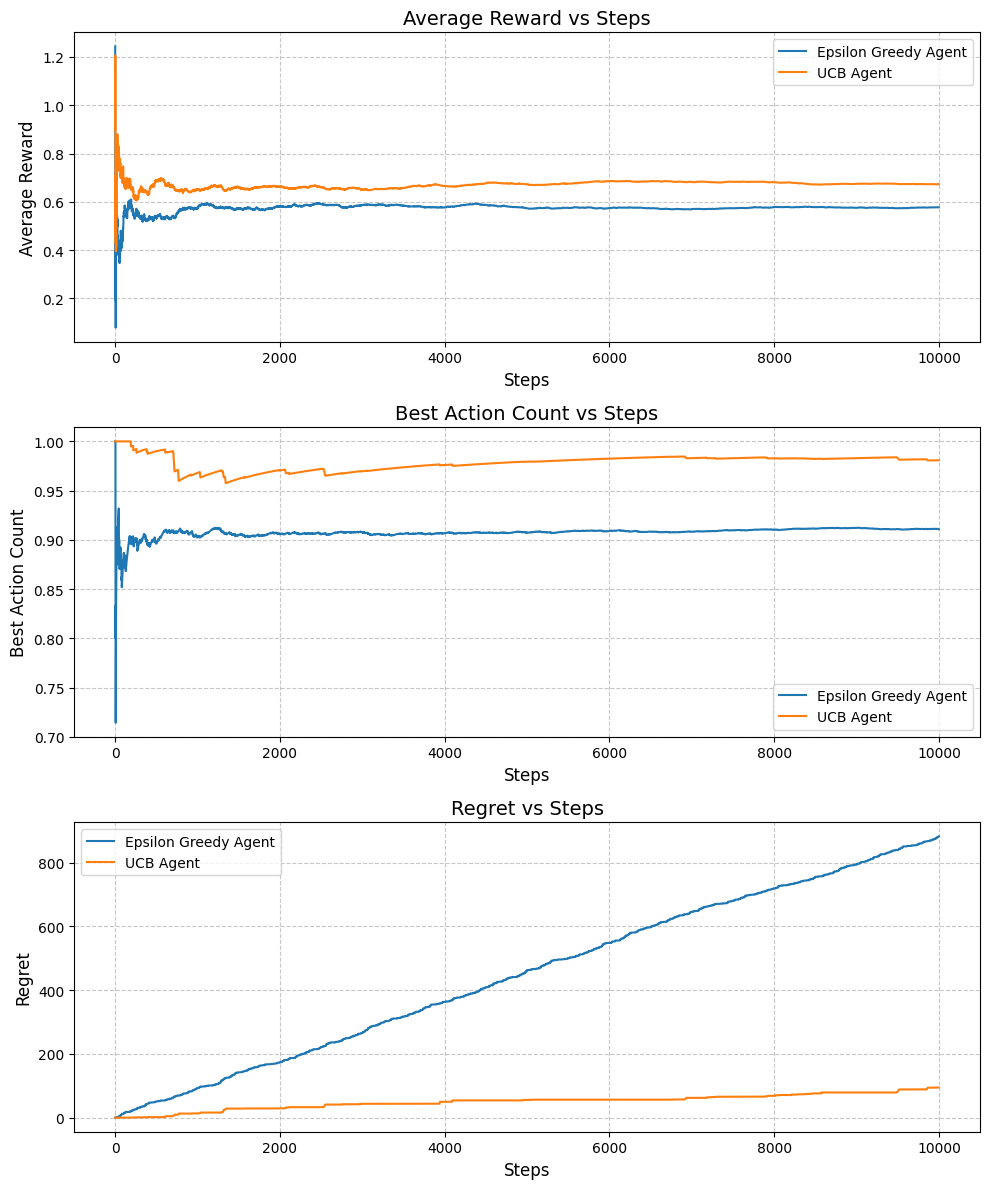

In [276]:
# run the epsilon greedy and UCB agents together
agents = [epsilon_greedy_agent, ucb_agent]
agent_names = ['Epsilon Greedy Agent', 'UCB Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

# Influence of epsilon in epsilon-greedy

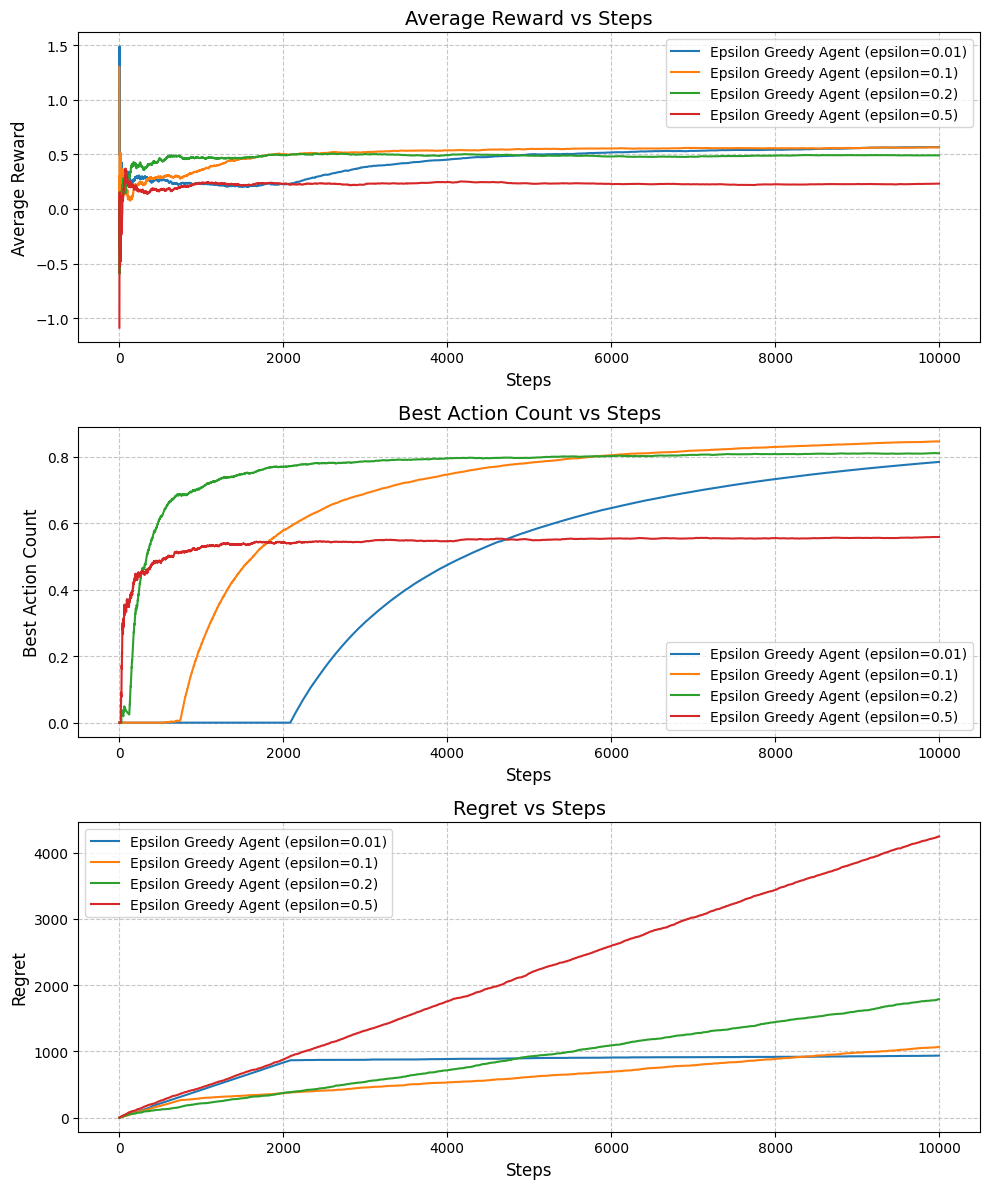

In [277]:
# run epsilon greedy for different values of epsilon
epsilons = [0.01, 0.1, 0.2, 0.5]
epsilon_agents = [EpsilonGreedy(bandit, epsilon) for epsilon in epsilons]
agent_names = [f'Epsilon Greedy Agent (epsilon={epsilon})' for epsilon in epsilons]
run_and_plot_for_agents(epsilon_agents, agent_names, bandit, 10000)

# Influence of c in UCB

/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: divide by zero encountered in log
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: invalid value encountered in sqrt
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: invalid value encountered in divide
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))
/tmp/ipykernel_603110/689004253.py:13: RuntimeWarning: divide by zero encountered in divide
  arm = np.argmax(self.estimated_means + self.c * np.sqrt((2 * np.log(self._T)) / self.action_counts))


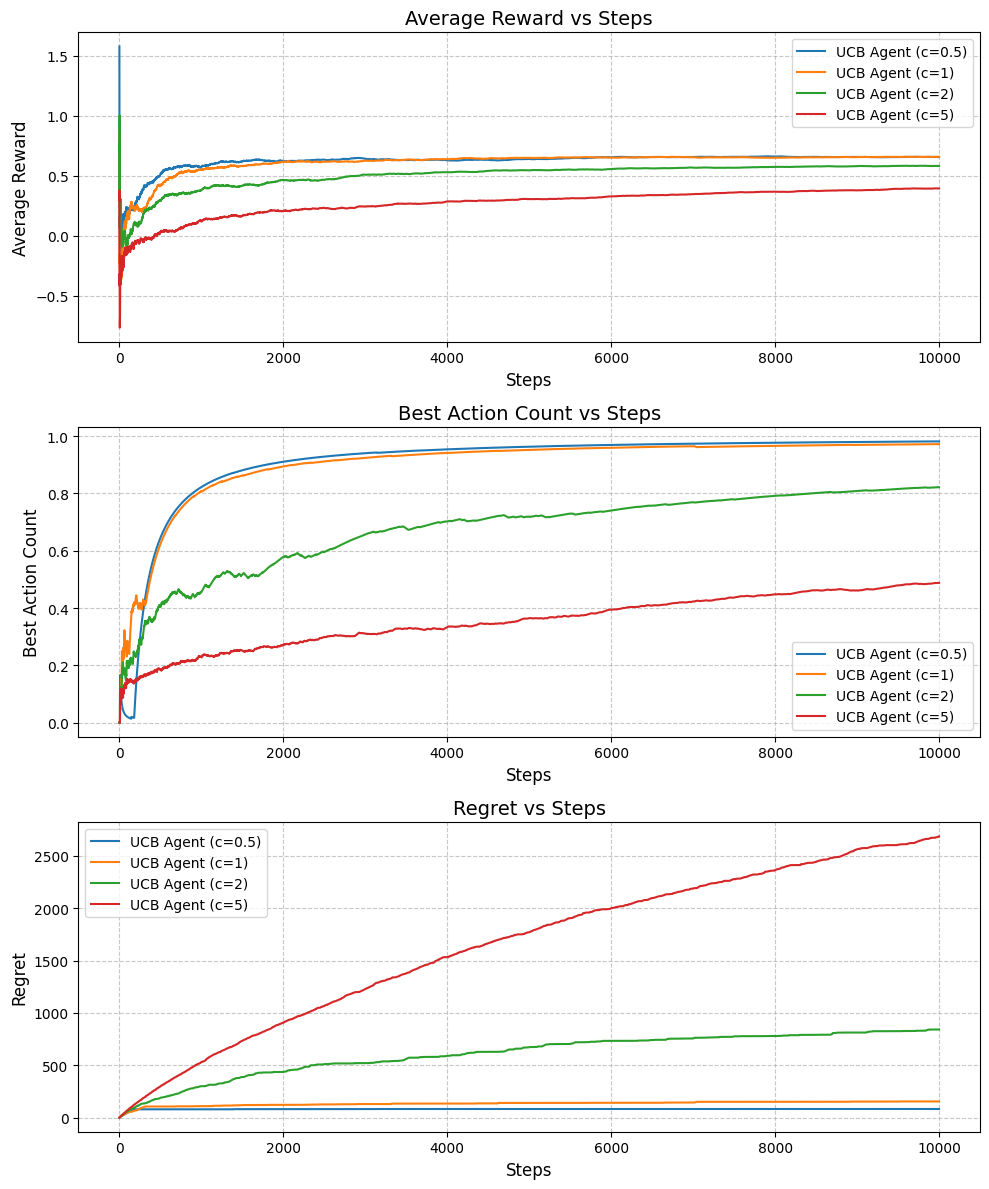

In [278]:
cs = [0.5, 1, 2, 5]
ucb_agents = [UCB(bandit, c) for c in cs]
agent_names = [f'UCB Agent (c={c})' for c in cs]
run_and_plot_for_agents(ucb_agents, agent_names, bandit, 10000)

# Visualization of UCB algorithm

# Thompson Sampling (optional)

For this part, we need to defined a new multi-armed Bandit class with rewards 0 or 1 (we could use the same class as before but it would need some work to make it work; let's keep it simple).

In [279]:
class MultiArmedBanditBernoulli:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.uniform(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]

    def play(self, arm: int) -> float:
        mean = self.means[arm]
        return np.random.binomial(1, mean)
    
# Create a MultiArmedBanditBernoulli instance and plot using a violin plot
bandit_bernoulli = MultiArmedBanditBernoulli(10)
print(bandit_bernoulli.means)


[0.0524228  0.92380225 0.35581117 0.31272249 0.93091921 0.99983675
 0.03951707 0.24042441 0.35681571 0.32149004]


In [280]:
## Thompson Sampling

class ThompsonSampling:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        # TODO
        pass

    def choose_action(self) -> int:
        # TODO: Implement the Thompson Sampling strategy
        pass

    def update(self, action: int, reward: float) -> None:
        # TODO: Implement the update rule
        pass


thompson_sampling_agent = ThompsonSampling(bandit_bernoulli)
agents = [thompson_sampling_agent]
agent_names = ['Thompson Sampling Agent']
run_and_plot_for_agents(agents, agent_names, bandit_bernoulli, 1000)

ValueError: operands could not be broadcast together with shapes (10000,) (1000,) 

In [ ]:
# TODO: visualize the Beta distributions for each arm of the bandit
def plot_beta_distributions(agent, bandit):
    # TODO
    pass